In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d balraj98/massachusetts-buildings-dataset

 99% 1.48G/1.49G [00:13<00:00, 141MB/s]
100% 1.49G/1.49G [00:14<00:00, 114MB/s]


In [ ]:
!unzip /content/massachusetts-buildings-dataset.zip

Archive:  /content/massachusetts-buildings-dataset.zip
  inflating: label_class_dict.csv    
  inflating: metadata.csv            
  inflating: png/test/22828930_15.png  
  inflating: png/test/22828990_15.png  
  inflating: png/test/22829050_15.png  
  inflating: png/test/23429020_15.png  
  inflating: png/test/23429080_15.png  
  inflating: png/test/23578960_15.png  
  inflating: png/test/23579005_15.png  
  inflating: png/test/23729035_15.png  
  inflating: png/test/23879080_15.png  
  inflating: png/test/24179065_15.png  
  inflating: png/test_labels/22828930_15.png  
  inflating: png/test_labels/22828990_15.png  
  inflating: png/test_labels/22829050_15.png  
  inflating: png/test_labels/23429020_15.png  
  inflating: png/test_labels/23429080_15.png  
  inflating: png/test_labels/23578960_15.png  
  inflating: png/test_labels/23579005_15.png  
  inflating: png/test_labels/23729035_15.png  
  inflating: png/test_labels/23879080_15.png  
  inflating: png/test_labels/24179065_15.png  

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np


class MDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transform = None):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.images = os.listdir(img_dir)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    mask[mask == 255.0] = 1.0
    if self.transform:
      aug = self.transform(image = image, mask = mask)
      image = aug["image"]
      mask = aug["mask"]
    
    return image, mask



In [ ]:
base_dir = "/content/png/"
x_train_dir = os.path.join(base_dir, "train")
y_train_dir = os.path.join(base_dir,"train_labels")

x_test_dir = os.path.join(base_dir, "test")
y_test_dir = os.path.join(base_dir, "test_labels")

x_val_dir = os.path.join(base_dir, "val")
y_val_dir = os.path.join(base_dir, "val_labels")

print(x_train_dir)

/content/png/train


In [ ]:
# defining the transform
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_height = 160
image_width = 160

train_transform = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

test_transforms = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


train_dataset = MDataset(x_train_dir, y_train_dir, train_transform)
test_dataset = MDataset(x_test_dir, y_test_dir, test_transform)

In [ ]:
## Dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle= True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(x.shape)
    print(preds.shape)
    assert preds.shape == x.shape

test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [ ]:
import torch.optim as optim 

lr = 1e-4
epochs = 50

model = UNET(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(epochs):
  print("Epoch {}/{}-------->".format(epoch, epochs))
  losses = 0
  for batch in iter(train_dataloader):
    img = batch[0].to(device)
    mask = batch[1].float().unsqueeze(1).to(device)
    optimizer.zero_grad()
    prediction = model(img)
    loss = loss_fn(prediction, mask)
    loss.backward()
    optimizer.step()
    losses += loss
  print("Loss = {}".format(losses))


Epoch 0/50-------->
Loss = 6.208554267883301
Epoch 1/50-------->
Loss = 5.76689338684082
Epoch 2/50-------->
Loss = 5.280811786651611
Epoch 3/50-------->
Loss = 4.985915660858154
Epoch 4/50-------->
Loss = 4.750585556030273
Epoch 5/50-------->
Loss = 4.579686641693115
Epoch 6/50-------->
Loss = 4.366240501403809
Epoch 7/50-------->
Loss = 4.168564319610596
Epoch 8/50-------->
Loss = 4.053488254547119
Epoch 9/50-------->
Loss = 3.9976305961608887
Epoch 10/50-------->
Loss = 3.9144442081451416
Epoch 11/50-------->
Loss = 3.880300998687744
Epoch 12/50-------->
Loss = 3.8152053356170654
Epoch 13/50-------->
Loss = 3.835872173309326
Epoch 14/50-------->
Loss = 3.7898454666137695
Epoch 15/50-------->
Loss = 3.773986339569092
Epoch 16/50-------->
Loss = 3.69401216506958
Epoch 17/50-------->
Loss = 3.6464478969573975
Epoch 18/50-------->
Loss = 3.645012617111206
Epoch 19/50-------->
Loss = 3.629215955734253
Epoch 20/50-------->
Loss = 3.6249072551727295
Epoch 21/50-------->
Loss = 3.5755927562

In [ ]:
with torch.no_grad():
  test_losses = 0
  i = 0
  for batch in iter(test_dataloader):
    test_img = batch[0].to(device)
    test_mask = batch[1].float().unsqueeze(1).to(device)
    test_pred = model(test_img)
    test_loss = loss_fn(test_pred, test_mask)
    test_losses += test_loss

  print(" Test Loss = {}".format(test_losses))


TypeError: ignored

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle= False)

In [ ]:
prediction = torch.sigmoid(prediction)

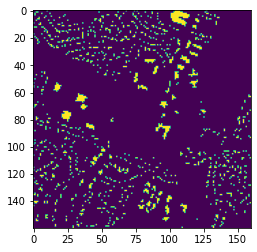

In [ ]:
import matplotlib.pyplot as plt
pred = prediction.cpu()
# pred[pred < 0.30] = 0
# pred[pred >= 0.30] = 1.0

target = mask.cpu()
%matplotlib inline
plt.imshow(pred[3].squeeze(0).detach())
plt.imshow(target[3].squeeze(0))

In [ ]:
figure = plt.figure(3,3,3)
figure.add_subplot(0,0,0)
i0 = img[2].cpu().view(160,160,3)

In [ ]:
import torchvision

pred = prediction.cpu()
pred = (pred > 0.3).float()
target = mask.cpu()
torchvision.utils.save_image(img[2].cpu(),"2_original.png")
torchvision.utils.save_image(pred[2],"2_prediction.png")
torchvision.utils.save_image(target[2],"2_label.png")

torchvision.utils.save_image(img[3].cpu(),"3_original.png")
torchvision.utils.save_image(pred[3],"3_prediction.png")
torchvision.utils.save_image(target[3],"3_label.png")

torchvision.utils.save_image(img[4].cpu(),"10_original.png")
torchvision.utils.save_image(pred[4],"10_prediction.png")
torchvision.utils.save_image(target[4],"10_label.png")